In [ ]:
pip install --user biosppy

In [ ]:
pip install --user PyWavelets

In [ ]:
pip install --user Pandas

In [ ]:
pip install --user --upgrade brevitas

Now FINN can only support 1D convolution and suqured data, so I convert the original ECG classification model from 1D to 2D. In step streamline, FINN will use `LowerConvsToMatMul` convert 2D coverlution operation into `Im2Col` and `MatMul`. But `Im2Col` doesn't support non-square images currently, so I `resize`the input data from (130) to (12* 12). When FINN compiles the model to IP core in FPGA, the convolution operations should be `INT` operations. So all of the input will be converted to INT Datatype at beginning. In order to achieve a high accuracy, the dataset will be quantized as UINT8 form (because the image RGB can be represented with UINT8 ). 

In [14]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import collections
import glob
import pywt
import math
import biosppy
import pandas as pd
from scipy import signal

%matplotlib inline

In [15]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

## 1. Process Data and Define Functions

Define a Quantization Function

In [38]:
def Quant(Vx, Q, RQM):
    return round(Q * Vx) - RQM


def ListQuant(data_list, quant_bits):
    
    data_min = min(data_list)
    data_max = max(data_list)

    
    Q = ((1 << quant_bits) - 1) * 1.0 / (data_max - data_min)
    RQM = (int)(round(Q*data_min))

    
    quant_data_list = []
    for x in data_list:
        quant_data = Quant(x, Q, RQM)
        quant_data_list.append(quant_data)
    quant_data_list = np.array(quant_data_list)
    return (Q, RQM, quant_data_list)

In [39]:
# Variables

path = "./mitDB/"
window_size = 160
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V', '/']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

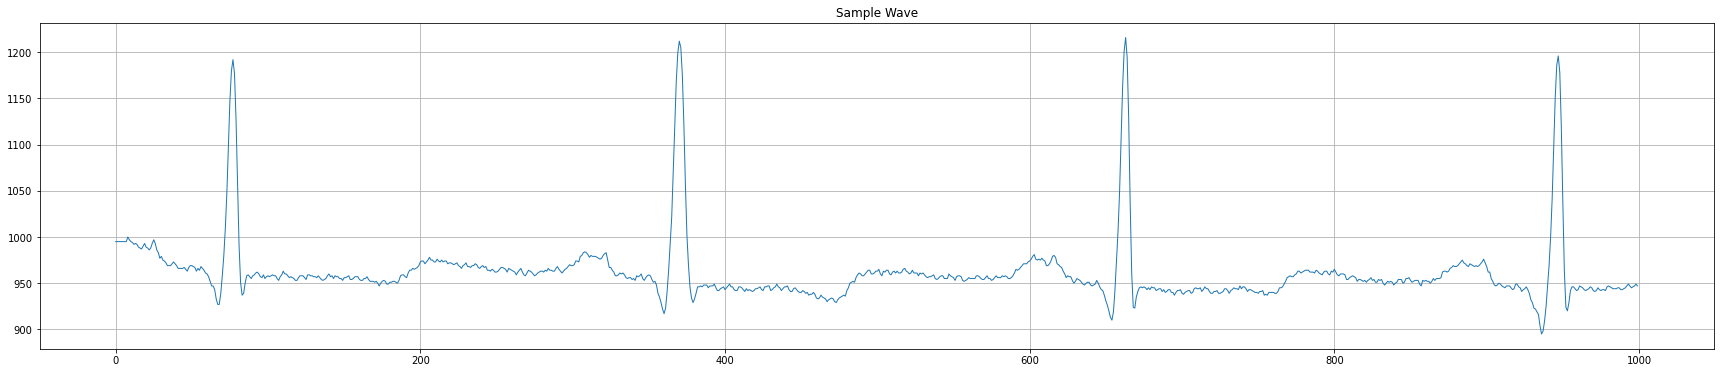

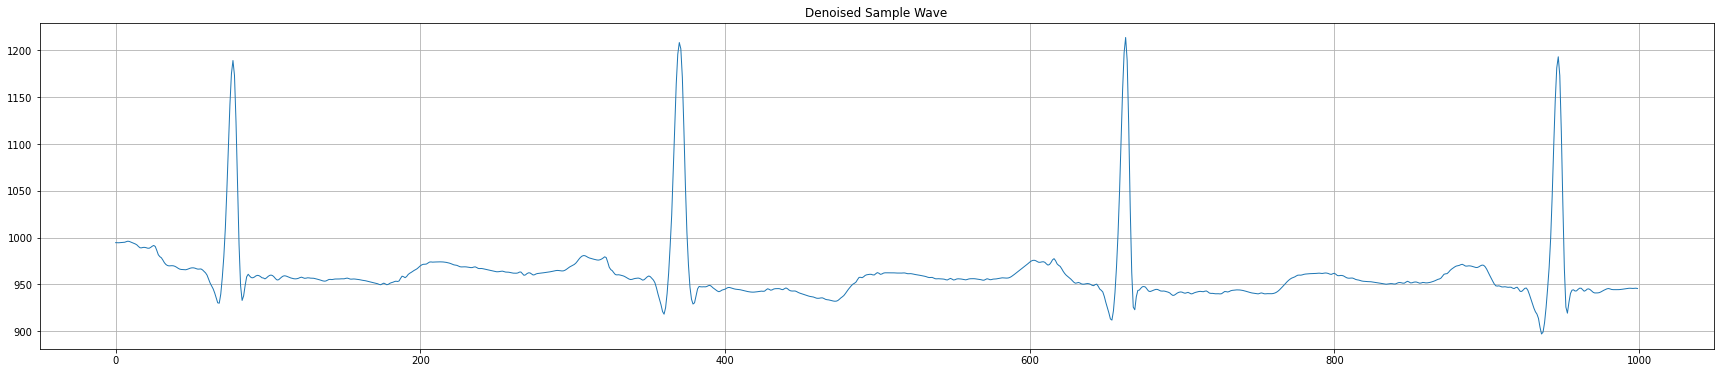

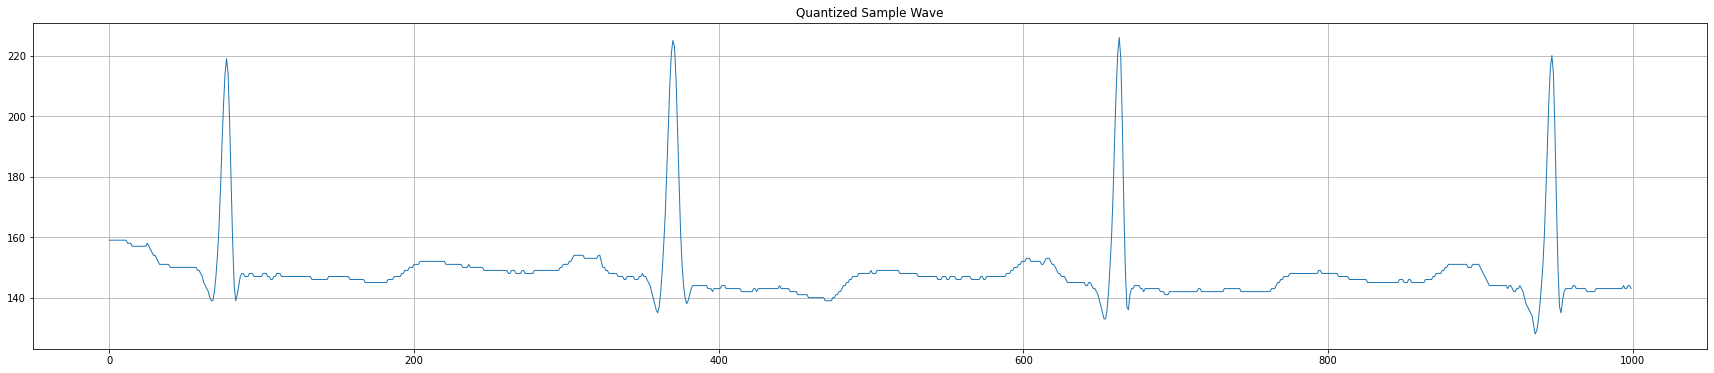

In [40]:
# Read files
filenames = next(os.walk(path))[2]

filenames.sort()

# Split and save .csv , .txt 
records = list()
annotations = list()

for f in filenames:
    filename, file_extension = os.path.splitext(f)
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)  
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1  
    
    
    
    ###### DWT w/ thresholding #####
    w = pywt.Wavelet('coif5')
    nl = 6
    coeffs = pywt.wavedec(signals, w, level=nl)
    
    # Apply the threshold.  Pseudocode here.
    new_coeffs = []
    for nc in coeffs:
        threshVal = (np.std(signals)/75)*(math.sqrt(2*math.log(len(signals))))
        tcoeff = pywt.threshold(nc, threshVal , mode='soft')
        new_coeffs.append(tcoeff)
    
    # IDWT
    renc = pywt.waverec(new_coeffs, w); 
    
    #Quantization
    renc_Q, renc_RQM, renc_QuantList = ListQuant(renc,quant_bits=8) #set the bit width for quantization
    
        
    if r == 0:
        # Plot first patient's signal
  #         plt.subplot(2,1,1)
        plt.title("Sample Wave")
        plt.plot(signals[:1000])
        plt.show()

  #         plt.subplot(2,1,2)
        plt.title("Denoised Sample Wave")
        plt.plot(renc[:1000])
        plt.show()
        
  #         plt.subplot(2,1,3)
        plt.title("Quantized Sample Wave")
        plt.plot(renc_QuantList[:1000])
        plt.show()
        

    # Read anotations: R position and Arrhythmia class
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type

            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                    pass
                else:
                    count_classes[arrhythmia_index] += 1
                    if(window_size < pos and pos < (len(renc_QuantList) - window_size)):
                        beat = signal.resample(renc_QuantList[pos-window_size+1:pos+window_size],130)
                        X.append(beat)
                        y.append(arrhythmia_index)

From the above Wave Diagrams, we can notice that the loss is very small, when the dataset is quantized.


Use `resize` to convert data from 1D to 2D.

In [41]:
#1D to 2D
X_resize=[]
for i in range(len(X)):
    x=X[i]
    x=np.trunc(x)
    x.resize((12,12),refcheck=False)
    X_resize.append(x)
 
print(X_resize[0])

[[150. 152. 151. 152. 151. 150. 151. 151. 150. 149. 150. 150.]
 [149. 150. 149. 148. 149. 148. 149. 148. 149. 148. 149. 148.]
 [148. 148. 147. 148. 148. 149. 148. 149. 148. 149. 149. 150.]
 [151. 151. 153. 154. 154. 153. 152. 153. 152. 153. 150. 148.]
 [148. 148. 147. 146. 146. 146. 146. 145. 146. 147. 145. 142.]
 [137. 136. 149. 176. 211. 225. 197. 156. 140. 139. 143. 143.]
 [144. 143. 143. 142. 143. 142. 144. 143. 143. 142. 143. 142.]
 [141. 141. 142. 142. 142. 143. 142. 143. 142. 143. 143. 143.]
 [142. 141. 141. 140. 141. 140. 140. 139. 140. 139. 139. 139.]
 [140. 141. 142. 144. 145. 146. 147. 148. 147. 148. 148. 148.]
 [149. 148. 149. 148. 149. 148. 148. 147. 148. 147.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]


In [42]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resize, y, test_size=0.33)

print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("y_train : ", collections.Counter(y_train))
print("y_test  : ", collections.Counter(y_test))

X_train :  28154
X_test  :  13867
y_train :  Counter({0: 6746, 1: 5373, 2: 4878, 4: 4812, 5: 4658, 3: 1687})
y_test  :  Counter({0: 3251, 1: 2698, 2: 2377, 5: 2365, 4: 2317, 3: 859})


In [43]:
print(np.shape(X_train[0]))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(12, 12)
(28154,)
(13867, 12, 12)
(13867,)


In [21]:
import warnings
from torch.utils.data.sampler import WeightedRandomSampler
from torch import optim 
import random
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler
import random
from torch.autograd import Variable

def imbalanced_loader(X_train,y_train,X_test,y_test,valid_size=.05,batch_size=100): # Split train into train + validation 
    
    warnings.filterwarnings("ignore") #torch bug
    print ('Getting Data... {}% Validation Set\n'.format(int(np.around(valid_size*100))))
    
    num_train = len(y_train)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    print("Batch Size:",batch_size)

    print('\nTrain Len=',len(train_idx),', Validation Len=',len(valid_idx), 'Test Len=',len(y_test))
                                                                                        
    class_sample_count = np.array([len(np.where(y_train[split:]==t)[0]) for t in np.unique(y_train[split:])])
        
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y_train[split:]])
    samples_weight = torch.from_numpy(samples_weight)
    train_sampler = WeightedRandomSampler(torch.tensor(samples_weight,dtype=torch.double), len(samples_weight))
    trainDataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train[split:]), torch.LongTensor(y_train[split:]))
    train_sampler = torch.utils.data.BatchSampler(sampler=train_sampler, batch_size=batch_size, drop_last=True)
    trainloader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=batch_size, num_workers=1, sampler= train_sampler)
  
    valDataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train[:split]), torch.LongTensor(y_train[:split]))
    sampler = torch.utils.data.RandomSampler(valDataset)
    sampler= torch.utils.data.BatchSampler(sampler, batch_size, drop_last=True)
    validloader = torch.utils.data.DataLoader(dataset = valDataset, batch_size=batch_size, num_workers=1,sampler=sampler)


    testset=[]
    for i,x in enumerate(X_test):
        testset.append((torch.from_numpy(x),torch.tensor([y_test[i]])))

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                           shuffle=False, num_workers=1)

    print("")
    dataloader = {"train": trainloader, "val": validloader}
    print('Train Size Batched=',int(len(dataloader['train'].dataset)/batch_size),', Validation Size Batched=',int(len(dataloader['val'].dataset)/batch_size),', Test Size Batched=',len(testloader))
    
    
    warnings.resetwarnings()
    return dataloader,testloader
  


In [44]:
import matplotlib.pyplot as plt 
import time 
import sklearn 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [45]:
def calc_accuracy(output,Y):
  
    # get acc_scores during training 
    max_vals, max_indices = torch.max(output,1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

def train_model(data_loader, model, criterion,optimizer, n_epochs=50,print_every=10,verbose=True,plot_results=True,validation=True):
  
    losses=[]
    accuracy=[]
    start= time.time()
    print('Training for {} epochs...\n'.format(n_epochs))
    for epoch in range(n_epochs):
        if verbose == True and epoch % print_every== 0:
            print('\n\nEpoch {}/{}:'.format(epoch+1, n_epochs))
        
        if validation == True: 
            evaluation=['train', 'val']
        else:
        
            evaluation=['train']
        
      # Each epoch has a training and validation phase
        for phase in evaluation:
            if phase == 'train': 
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0

          # Iterate over data.
            for hb,labels in data_loader[phase]:
                for hb_index,label in enumerate(labels):
                    HB, label = hb[hb_index].unsqueeze(1).cpu(), label.cpu()

                # forward + backward + optimize
                    outputs = model(HB)
                    acc= calc_accuracy(outputs,label)
                    loss = criterion(outputs, label)#loss function 
                # zero the parameter (weight) gradients
                    optimizer.zero_grad()

                # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                    # update the weights
                        optimizer.step()

                # print loss statistics
                    running_loss += loss.item()

                losses.append(running_loss)
                accuracy.append(acc)

            if verbose == True and epoch % print_every== 0: 
                print('{} loss: {:.4f} | acc: {:.4f}|'.format(phase, running_loss,acc), end=' ')
    if verbose == True:        
        print('\nFinished Training  | Time:{}'.format(time.time()-start))
    if plot_results == True:
        plt.figure(figsize=(10,10))
        plt.plot(losses[0::2],label='train_loss')
        if validation == True:
            plt.plot(losses[1::2],label='validation_loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.draw()
        
        plt.figure(figsize=(10,10))
        plt.plot(accuracy[0::2],label='train_acc')
        if validation == True:
            plt.plot(accuracy[1::2],label='validation_acc')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.draw()
  
    return model 


def evaluate(testloader, trained_model,verbose= True):
    
    truth=[]
    preds=[]
    for hb,label in testloader:
        HB, label = hb.float().unsqueeze(1).cpu(), label.cpu()
        outputs = trained_model(HB)
        _, predicted = torch.max(outputs, 1)
        preds.append(predicted.cpu().numpy().tolist())
        truth.append(label.cpu().numpy().tolist())
  
    preds_flat = [item for sublist in preds for item in sublist]
    truth_flat = [item for sublist in truth for item in sublist] 
 
    if verbose == True:
        print('\nEvaluating....')
        print("TEST ACC:",accuracy_score(truth_flat,preds_flat))
        print(classification_report(truth_flat,preds_flat))
  
    return preds_flat,truth_flat

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

## 2. Quantized Model with Brevitas

In [46]:
import onnx
import torch
from brevitas.nn import QuantConv2d, QuantIdentity, QuantMaxPool2d, QuantLinear,QuantDropout,QuantReLU, QuantAvgPool2d
from brevitas.core.quant import QuantType
import torch.nn as nn

This model's architecture is different from original ECG classifcation model, because current implementation of streamlining is highly network-specific, it doesn't support original model's architechture. I modify the model to adapt it to streamline operation. Otherwise the model will be separated into several parts and only one part can be compiled as IP core, the others should be processed in software/on CPU.

In [47]:
class QuantizedECG(nn.Module):
    def __init__(self,input_size,num_classes):
        super(QuantizedECG,self).__init__()
        self.cnn1=QuantConv2d(in_channels=input_size,out_channels=32,kernel_size=3,padding=0,bias=True,weight_bit_width=4) 
        self.maxpool1=nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn2=QuantConv2d(in_channels=32,out_channels=32,kernel_size=3,padding=0,bias=True,weight_bit_width=4) 
        self.cnn2_1=QuantConv2d(in_channels=32,out_channels=32,kernel_size=3,padding=0,bias=True,weight_bit_width=4)
                
        self.drop= QuantDropout(p=0.5)
        self.dense=QuantLinear(32,num_classes,bias=True,weight_bit_width=4)
        self.relu1=QuantReLU(bit_width=4)
        self.relu2=QuantReLU(bit_width=4)
        self.relu3=QuantReLU(bit_width=4)
        
        
    def forward(self,x):
        x=self.cnn1(x)
        x=self.relu1(x)
        x=self.maxpool1(x)
        
        x=self.cnn2(x)
        x=self.cnn2_1(x)
        x=self.relu2(x)
        
        x=x.view(x.size(0),-1)
        x=self.drop(x)
        x=self.dense(x)
        x=self.relu3(x)
        return x

In [48]:
BATCH_SIZE = 100
Quant_dataloader,Quant_testloader = imbalanced_loader(X_train=X_train,y_train=y_train,
                                                      X_test=X_test,y_test=y_test,
                                                      valid_size=.05,batch_size=BATCH_SIZE)

Getting Data... 5% Validation Set

Batch Size: 100

Train Len= 26747 , Validation Len= 1407 Test Len= 13867

Train Size Batched= 267 , Validation Size Batched= 14 , Test Size Batched= 139


In [49]:
n_classes=6
brevitas_model = QuantizedECG(input_size=1,num_classes=n_classes)

In [50]:
LEARNING_RATE = 0.0001
optimizer = optim.Adam(brevitas_model.parameters(),lr = LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

Training for 100 epochs...



Epoch 1/100:
train loss: 496.8916 | acc: 0.2800| val loss: 21.3087 | acc: 0.2400| 

Epoch 11/100:
train loss: 190.4175 | acc: 0.6200| val loss: 5.1507 | acc: 0.9200| 

Epoch 21/100:
train loss: 118.3703 | acc: 0.8400| val loss: 2.7051 | acc: 0.9600| 

Epoch 31/100:
train loss: 90.6320 | acc: 0.8800| val loss: 1.9346 | acc: 0.9900| 

Epoch 41/100:
train loss: 73.1818 | acc: 0.9000| val loss: 1.6437 | acc: 0.9500| 

Epoch 51/100:
train loss: 62.2392 | acc: 0.9500| val loss: 1.3707 | acc: 0.9500| 

Epoch 61/100:
train loss: 56.9436 | acc: 0.9100| val loss: 1.3526 | acc: 0.9900| 

Epoch 71/100:
train loss: 52.9430 | acc: 0.9600| val loss: 1.3593 | acc: 0.9700| 

Epoch 81/100:
train loss: 53.3043 | acc: 0.9500| val loss: 1.3587 | acc: 0.9800| 

Epoch 91/100:
train loss: 45.0126 | acc: 0.9500| val loss: 1.0255 | acc: 1.0000| 
Finished Training  | Time:1110.7989566326141

Evaluating....
TEST ACC: 0.9783659046657532
              precision    recall  f1-score   su

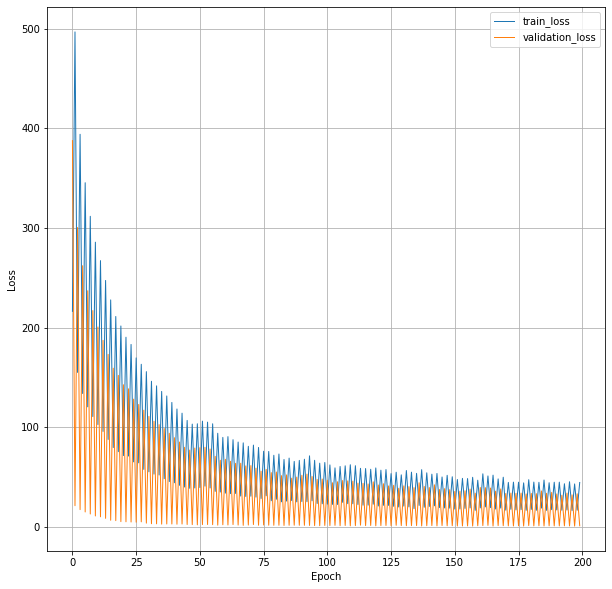

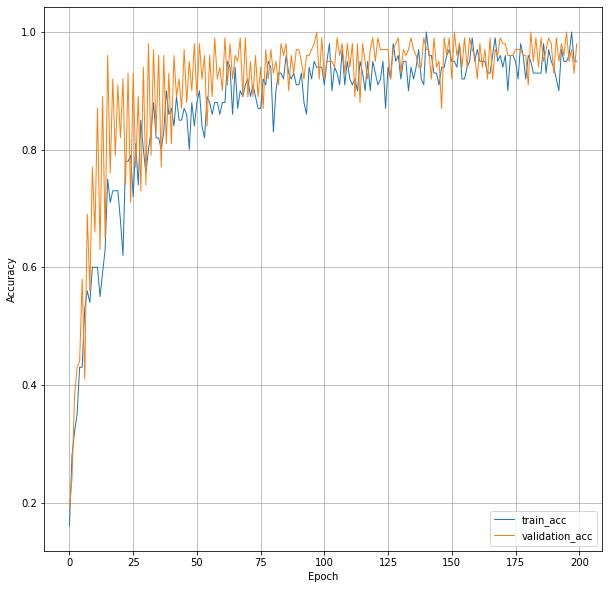

In [51]:
EPOCHS=100
trained_classifier = train_model(data_loader = Quant_dataloader, model = brevitas_model, 
                                 criterion = criterion,optimizer = optimizer , 
                                 n_epochs = EPOCHS,print_every = 10,
                                 verbose=True,plot_results=True, validation=True)

preds,truth = evaluate(testloader=Quant_testloader, trained_model = trained_classifier,verbose=True)

Normalized confusion matrix


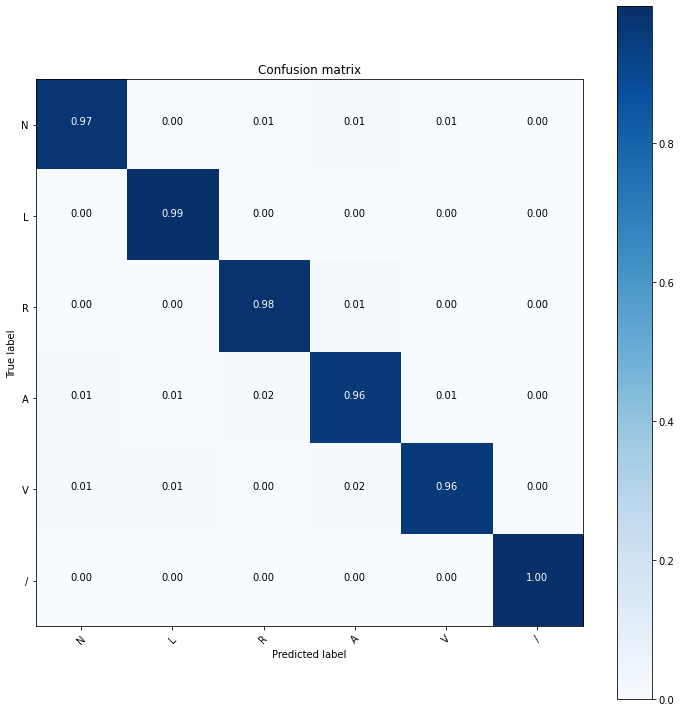

In [52]:
cm = confusion_matrix(y_true=truth, y_pred=preds)
plot_confusion_matrix(cm=cm,normalize=True,classes=classes)

Save the model's parameters

In [53]:
torch.save(brevitas_model.state_dict(),'./save/brevitas_2D_model_parameter.pth')

## 3. Export to ONNX

In [37]:
import brevitas.onnx as bo

In [ ]:
export_onnx_path="./save/ECG_brevitas_2D.onnx"
input_shape=(1,1,12,12)
bo.export_finn_onnx(brevitas_model, input_shape, export_onnx_path)

In [55]:
from finn.core.modelwrapper import ModelWrapper
from finn.core.datatype import DataType

In [56]:
model_file="./save/ECG_brevitas_2D.onnx"

model=ModelWrapper(model_file)
model.set_tensor_datatype(model.graph.input[0].name, DataType.UINT8)
model.save(model_file)

In [3]:
import netron
from IPython.display import IFrame

def showInNetron(model_filename):
    netron.start(model_filename, address=("0.0.0.0",8081))
    return IFrame(src="http://0.0.0.0:8081/",width="100%",height=400)

In [57]:
showInNetron("./save/ECG_brevitas_2D.onnx")

Stopping http://0.0.0.0:8081
Serving './save/ECG_brevitas_2D.onnx' at http://0.0.0.0:8081


## 4. Build the Quantized Model with FINN

In [58]:
import onnx
from finn.util.test import get_test_model_trained
import brevitas.onnx as bo
from finn.core.modelwrapper import ModelWrapper
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.fold_constants import FoldConstants
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs

model = ModelWrapper("./save/ECG_brevitas_2D.onnx")
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(RemoveStaticGraphInputs())
model.save("./save/ECG_brevitas_tidy.onnx")

In [59]:
showInNetron("./save/ECG_brevitas_tidy.onnx")

Stopping http://0.0.0.0:8081
Serving './save/ECG_brevitas_tidy.onnx' at http://0.0.0.0:8081


Insert `TopK` at the end, then the last operation `Mul` can be absorbed by `TopK`, otherwise `Mul` should be done on CPU.

In [60]:
from finn.transformation.insert_topk import InsertTopK
from finn.transformation.infer_datatypes import InferDataTypes

# postprocessing: insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = "./save/ECG_brevitas_post.onnx"
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

showInNetron("./save/ECG_brevitas_post.onnx")

Stopping http://0.0.0.0:8081
Serving './save/ECG_brevitas_post.onnx' at http://0.0.0.0:8081


Set customized target_fps and fpga_part to generate IP core.

In [61]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg

model_file = "./save/ECG_brevitas_post.onnx"

rtlsim_output_dir = "./save/output_ipstitch_ooc_rtlsim"

cfg = build.DataflowBuildConfig(
    output_dir          = rtlsim_output_dir,
    target_fps          = 10000,
    synth_clk_period_ns = 20.0,
    fpga_part           = "xc7z020clg400-1",
    generate_outputs=[
        build_cfg.DataflowOutputType.STITCHED_IP,
        build_cfg.DataflowOutputType.RTLSIM_PERFORMANCE,
        build_cfg.DataflowOutputType.OOC_SYNTH,
    ]
)

build.build_dataflow_cfg(model_file, cfg)

Building dataflow accelerator from ./save/ECG_brevitas_post.onnx
Intermediate outputs will be generated in /tmp/finn_dev_wenlong
Final outputs will be generated in ./save/output_ipstitch_ooc_rtlsim
Build log is at ./save/output_ipstitch_ooc_rtlsim/build_dataflow.log
Running step: step_tidy_up [1/16]
Running step: step_streamline [2/16]
Running step: step_convert_to_hls [3/16]
Running step: step_create_dataflow_partition [4/16]
Running step: step_target_fps_parallelization [5/16]
Running step: step_apply_folding_config [6/16]
Running step: step_generate_estimate_reports [7/16]
Running step: step_hls_codegen [8/16]
Running step: step_hls_ipgen [9/16]
Running step: step_set_fifo_depths [10/16]
Running step: step_create_stitched_ip [11/16]
Running step: step_measure_rtlsim_performance [12/16]
Running step: step_make_pynq_driver [13/16]
Running step: step_out_of_context_synthesis [14/16]
Running step: step_synthesize_bitfile [15/16]
Running step: step_deployment_package [16/16]
Completed su

0

Check the utilization resource and permormance of the generated IP core.

In [62]:
! cat {rtlsim_output_dir}/report/ooc_synth_and_timing.json

{
  "vivado_proj_folder": "/tmp/finn_dev_wenlong/synth_out_of_context_lpnd4nou/results_finn_design_wrapper",
  "LUT": 8110.0,
  "FF": 12228.0,
  "DSP": 0.0,
  "BRAM": 5.0,
  "WNS": 4.762,
  "": 0,
  "fmax_mhz": 65.6254101588135,
  "estimated_throughput_fps": 14241.625468492512
}

In [63]:
! cat {rtlsim_output_dir}/report/rtlsim_performance.json

{
  "cycles": 100121,
  "runtime[ms]": 2.00242,
  "throughput[images/s]": 9987.9146233058,
  "DRAM_in_bandwidth[Mb/s]": 1.4382597057560351,
  "DRAM_out_bandwidth[Mb/s]": 0.0099879146233058,
  "fclk[mhz]": 50.0,
  "N": 20,
  "latency_cycles": 12436
}

In [64]:
! cat {rtlsim_output_dir}/final_hw_config.json

{
  "Defaults": {},
  "ConvolutionInputGenerator_0": {
    "SIMD": 1,
    "ram_style": "distributed"
  },
  "StreamingDataWidthConverter_Batch_0": {
    "impl_style": "hls"
  },
  "StreamingFIFO_2": {
    "ram_style": "auto",
    "depth": 32,
    "impl_style": "rtl"
  },
  "StreamingFCLayer_Batch_0": {
    "PE": 1,
    "SIMD": 9,
    "ram_style": "auto",
    "resType": "lut",
    "mem_mode": "decoupled",
    "runtime_writeable_weights": 0
  },
  "StreamingDataWidthConverter_Batch_1": {
    "impl_style": "hls"
  },
  "StreamingDataWidthConverter_Batch_2": {
    "impl_style": "hls"
  },
  "StreamingFIFO_6": {
    "ram_style": "auto",
    "depth": 256,
    "impl_style": "rtl"
  },
  "ConvolutionInputGenerator_1": {
    "SIMD": 1,
    "ram_style": "distributed"
  },
  "StreamingDataWidthConverter_Batch_3": {
    "impl_style": "hls"
  },
  "StreamingFIFO_8": {
    "ram_style": "auto",
    "depth": 128,
    "impl_style": "rtl"
  },
  "StreamingFCLayer_Batch_1": {
    "PE": 2,
    "SIMD": 9,


In [65]:
showInNetron("./save/output_ipstitch_ooc_rtlsim/intermediate_models/1_step_tidy_up.onnx")

Stopping http://0.0.0.0:8081
Serving './save/output_ipstitch_ooc_rtlsim/intermediate_models/1_step_tidy_up.onnx' at http://0.0.0.0:8081


In [66]:
showInNetron("./save/output_ipstitch_ooc_rtlsim/intermediate_models/2_step_streamline.onnx")

Stopping http://0.0.0.0:8081
Serving './save/output_ipstitch_ooc_rtlsim/intermediate_models/2_step_streamline.onnx' at http://0.0.0.0:8081


Check if all of the operations in model are compiled.

In [67]:
showInNetron("./save/output_ipstitch_ooc_rtlsim/intermediate_models/dataflow_parent.onnx")

Stopping http://0.0.0.0:8081
Serving './save/output_ipstitch_ooc_rtlsim/intermediate_models/dataflow_parent.onnx' at http://0.0.0.0:8081


## 5.Verification

Reload the original quantized model, and input a random test data to get golden_output. Also compare the true label and prediction label.

In [68]:
import onnx
import torch

original_model = QuantizedECG(input_size=1,num_classes=6)
state_dict = torch.load('./save/brevitas_2D_model_parameter.pth')
original_model.load_state_dict(state_dict)
original_model.eval()

i = random.randint(0,len(X_test))

input_tensor = torch.from_numpy(X_test[i]).float()
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.unsqueeze(0)

print(input_tensor.shape)
print("input:",input_tensor)
print("Label_true:",y_test[i])

output_golden = original_model.forward(input_tensor).detach().numpy()
print("output_golden:",output_golden)
output_golden_label = torch.from_numpy(output_golden)
output_golden_label = torch.max(output_golden_label,1)[1]
print("Label_pred:",output_golden_label)

torch.Size([1, 1, 12, 12])
input: tensor([[[[119., 117., 120., 121., 123., 124., 125., 126., 127., 126., 127.,
           127.],
          [126., 125., 125., 124., 125., 124., 125., 124., 125., 124., 125.,
           124.],
          [125., 124., 125., 124., 125., 124., 125., 124., 123., 121., 119.,
           117.],
          [117., 116., 117., 116., 116., 115., 116., 115., 116., 117., 116.,
           117.],
          [116., 117., 116., 117., 118., 119., 118., 119., 118., 118., 124.,
           136.],
          [148., 158., 171., 182., 189., 188., 179., 164., 149., 132., 112.,
            98.],
          [ 91.,  88.,  88.,  88.,  92.,  95.,  99., 101., 104., 105., 106.,
           107.],
          [106., 106., 105., 104., 104., 103., 102., 103., 102., 103., 103.,
           104.],
          [105., 106., 108., 109., 111., 112., 114., 116., 117., 119., 120.,
           121.],
          [122., 123., 124., 125., 125., 126., 125., 125., 124., 125., 124.,
           124.],
          [123.,

### Simulation using Python

Check the model before converted HLS layers, if it works well.

In [69]:
import numpy as np
from finn.core.modelwrapper import ModelWrapper
import onnx.numpy_helper as nph

input_test1 = torch.from_numpy(X_test[i]).float()
input_test1 = input_test1.unsqueeze(0)
input_test1 = input_test1.unsqueeze(0)

input_numpy = (input_test1.numpy()).astype(np.float32)#.tolist()
input_dict = {"global_in": input_numpy}
print("input:",input_numpy)
print("Label_true:",y_test[i])

model_for_sim = ModelWrapper("./save/output_ipstitch_ooc_rtlsim/intermediate_models/2_step_streamline.onnx")

input: [[[[119. 117. 120. 121. 123. 124. 125. 126. 127. 126. 127. 127.]
   [126. 125. 125. 124. 125. 124. 125. 124. 125. 124. 125. 124.]
   [125. 124. 125. 124. 125. 124. 125. 124. 123. 121. 119. 117.]
   [117. 116. 117. 116. 116. 115. 116. 115. 116. 117. 116. 117.]
   [116. 117. 116. 117. 118. 119. 118. 119. 118. 118. 124. 136.]
   [148. 158. 171. 182. 189. 188. 179. 164. 149. 132. 112.  98.]
   [ 91.  88.  88.  88.  92.  95.  99. 101. 104. 105. 106. 107.]
   [106. 106. 105. 104. 104. 103. 102. 103. 102. 103. 103. 104.]
   [105. 106. 108. 109. 111. 112. 114. 116. 117. 119. 120. 121.]
   [122. 123. 124. 125. 125. 126. 125. 125. 124. 125. 124. 124.]
   [123. 124. 122. 123. 122. 123. 123. 124. 124. 126.   0.   0.]
   [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]]]
Label_true: 1


In [70]:
import finn.core.onnx_exec as oxe
output_dict = oxe.execute_onnx(model_for_sim, input_dict)
output_pysim = output_dict[list(output_dict.keys())[0]]
print("Results for Simulation: Label_pred",output_pysim)

Results for Simulation: Label_pred [[1]]


Get correct output, Label_true = Label_pred.

Test 500 random data from test_dataset.

In [73]:
# test the performance

def test_performance(test_num, test_model):
    model_error=0
    finn_error=0
    for test in range(test_num):
        i = random.randint(0,len(X_test))
        input_tensor = torch.from_numpy(X_test[i]).float()
        input_tensor = input_tensor.unsqueeze(0)
        input_tensor = input_tensor.unsqueeze(0)
        output_golden = original_model.forward(input_tensor).detach().numpy()
        output_golden_label = torch.from_numpy(output_golden)
        output_golden_label = torch.max(output_golden_label,1)[1]
        input_numpy = (input_tensor.numpy()).astype(np.float32)
        input_dict = {"global_in": input_numpy}
        output_dict = oxe.execute_onnx(model_for_sim, input_dict)
        output_pysim = output_dict[list(output_dict.keys())[0]]
        Label_true = y_test[i]
        if output_golden_label!=Label_true:
            model_error+=1
        if output_pysim!=Label_true:
            finn_error+=1
    print("Total test:",test_num)
    print("Error in orignal model:", model_error)
    print("Error in FINN model:",finn_error)

In [74]:
test=test_performance(test_num=500, test_model=model_for_sim)

Total test: 500
Error in orignal model: 9
Error in FINN model: 11


### Simulation (cppsim) using C++

After the nodes have been converted to HLS layers, the simulation using C++ can be used. To do this, the input tensor is stored in an .npy file and C++ code is generated that reads the values from the .npy array, streams them to the corresponding finn-hlslib function and writes the result to a new .npy file. This in turn can be read in Python and processed in the FINN flow.

In [75]:
model_for_cppsim = ModelWrapper("./save/output_ipstitch_ooc_rtlsim/intermediate_models/6_step_apply_folding_config.onnx")

In [76]:
from finn.transformation.fpgadataflow.prepare_cppsim import PrepareCppSim
from finn.transformation.fpgadataflow.compile_cppsim import CompileCppSim
from finn.transformation.general import GiveUniqueNodeNames

model_for_cppsim = model_for_cppsim.transform(GiveUniqueNodeNames())
model_for_cppsim = model_for_cppsim.transform(PrepareCppSim())
model_for_cppsim = model_for_cppsim.transform(CompileCppSim())

In [77]:
model_for_cppsim.save("./save/ECG_brevitas_for_cppsim.onnx")
showInNetron("./save/ECG_brevitas_for_cppsim.onnx")

Stopping http://0.0.0.0:8081
Serving './save/ECG_brevitas_for_cppsim.onnx' at http://0.0.0.0:8081


In [78]:
from finn.custom_op.registry import getCustomOp

fc0 = model_for_cppsim.graph.node[1]
fc0w = getCustomOp(fc0)
code_gen_dir = fc0w.get_nodeattr("code_gen_dir_cppsim")
!ls {code_gen_dir}

compile.sh			    memblock_0.dat  thresh.h
execute_StreamingFCLayer_Batch.cpp  node_model	    weights.npy


In [79]:
from finn.transformation.fpgadataflow.set_exec_mode import SetExecMode

model_for_cppsim = model_for_cppsim.transform(SetExecMode("cppsim"))
model_for_cppsim.save("./save/ECG_brevitas_for_cppsim.onnx")

In [80]:
parent_model = ModelWrapper("./save/output_ipstitch_ooc_rtlsim/intermediate_models/dataflow_parent.onnx")
sdp_node = parent_model.graph.node[1]
child_model = "./save/ECG_brevitas_for_cppsim.onnx"
getCustomOp(sdp_node).set_nodeattr("model", child_model)
output_dict = oxe.execute_onnx(parent_model, input_dict)
output_cppsim = output_dict[list(output_dict.keys())[0]]
output_cppsim

array([[1]])

Get correct output, Label_true = Label_pred.

In [81]:
test=test_performance(test_num=500, test_model=model_for_cppsim)

Total test: 500
Error in orignal model: 7
Error in FINN model: 7


### Emulation (rtlsim) using PyVerilator

The emulation using PyVerilator can be done after IP blocks are generated from the corresponding HLS layers. Pyverilator is a tool which makes it possible to simulate verilog files using verilator via a python interface.

#### Emulation of stitched IP

In [ ]:
from finn.transformation.fpgadataflow.prepare_rtlsim import PrepareRTLSim
from finn.transformation.fpgadataflow.prepare_ip import PrepareIP
from finn.transformation.fpgadataflow.hlssynth_ip import HLSSynthIP
from finn.transformation.fpgadataflow.insert_dwc import InsertDWC
from finn.transformation.fpgadataflow.insert_fifo import InsertFIFO
from finn.transformation.fpgadataflow.create_stitched_ip import CreateStitchedIP

test_fpga_part = "xc7z020clg400-1"
target_clk_ns = 20

child_model = ModelWrapper("./save/output_ipstitch_ooc_rtlsim/intermediate_models/6_step_apply_folding_config.onnx")
child_model = child_model.transform(InsertDWC())
child_model = child_model.transform(InsertFIFO())
child_model = child_model.transform(GiveUniqueNodeNames())
child_model = child_model.transform(PrepareIP(test_fpga_part, target_clk_ns))
child_model = child_model.transform(HLSSynthIP())
child_model = child_model.transform(CreateStitchedIP(test_fpga_part, target_clk_ns))
child_model = child_model.transform(PrepareRTLSim())
child_model.set_metadata_prop("exec_mode","rtlsim")
child_model.save("./save/ECG_brevitas_dataflow_child.onnx")

In [83]:
showInNetron("./save/ECG_brevitas_dataflow_child.onnx")

Stopping http://0.0.0.0:8081
Serving './save/ECG_brevitas_dataflow_child.onnx' at http://0.0.0.0:8081


In [ ]:
# parent model
model_for_rtlsim = ModelWrapper("./save/output_ipstitch_ooc_rtlsim/intermediate_models/dataflow_parent.onnx")
# reference child model
sdp_node = getCustomOp(model_for_rtlsim.graph.node[1])
sdp_node.set_nodeattr("model","./save/ECG_brevitas_dataflow_child.onnx")
output_dict = oxe.execute_onnx(model_for_rtlsim, input_dict)
output_rtlsim = output_dict[list(output_dict.keys())[0]]
output_rtlsim 

Get correct output, Label_true = Label_pred.

In [85]:
test=test_performance(test_num=500, test_model=model_for_rtlsim)

Total test: 500
Error in orignal model: 12
Error in FINN model: 13
